In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
import plotly.figure_factory as ff
from plotnine import *
import matplotlib

# 导入数据

In [18]:
data_excel = pd.ExcelFile("./data/2023_MCM_Problem_Y_Boats.xlsx")
data_excel.sheet_names

['Monohulled Sailboats ', 'Catamarans']

合并excel表格的两个sheets并打上'Hull Num'标签。

In [19]:
df_mono = data_excel.parse(sheet_name='Monohulled Sailboats ')
df_mono.insert(loc=len(df_mono.columns), column='Hull Num',value='Monohulled Sailboats')
df_multi = data_excel.parse(sheet_name= 'Catamarans')
df_multi.insert(loc=len(df_multi.columns), column='Hull Num',value='Catamarans')
df = pd.concat([df_mono, df_multi])
df.rename(columns={'Length \n(ft)':'Length (ft)'}, inplace=True)
df

,Make,Variant,Length (ft),Geographic Region,Country/Region/State,Listing Price (USD),Year,Hull Num
0,Alubat,Ovni 395,41.0,Europe,France,267233,2005,Monohulled Sailboats
1,Bavaria,38 Cruiser,38.0,Europe,Croatia,75178,2005,Monohulled Sailboats
2,Bavaria,38 Cruiser,38.0,Europe,Croatia,66825,2005,Monohulled Sailboats
3,Bavaria,38 Cruiser,38.0,Europe,Croatia,54661,2005,Monohulled Sailboats
4,Bavaria,38 Cruiser,38.0,Europe,Croatia,53447,2005,Monohulled Sailboats
...,...,...,...,...,...,...,...,...
1140,Lagoon,50,48.0,Europe,Greece,788937,2019,Catamarans
1141,Lagoon,50,48.0,Europe,Greece,788937,2019,Catamarans
1142,Bali,5.4,55.5,Europe,Greece,1246325,2019,Catamarans
1143,Bali,5.4,55.5,Europe,Italy,811143,2019,Catamarans


# Data Cleaning

In [20]:
df_invalid_row = df[df.isnull().values == True]
df_invalid_row

,Make,Variant,Length (ft),Geographic Region,Country/Region/State,Listing Price (USD),Year,Hull Num
1586,Beneteau,Oceanis 54,54.0,USA,NaN,479805,2013,Monohulled Sailboats
1592,Delphia,46 cc,46.0,Europe,NaN,314606,2013,Monohulled Sailboats
1716,Bavaria,Cruiser 46,46.0,Europe,NaN,201640,2014,Monohulled Sailboats


注意到只在'Country/Region/State'这一列会出现NaN值，没有其他问题，这里选择剔除这几行，可以作为interesting findings看能不能通过机器学习的回归方法猜测这几艘船的'Country/Region/State'。

In [21]:
df_cleaned = df.dropna()
df_cleaned.to_excel('./data/2023_MCM_Problem_Y_Boats_cleaned.xlsx')

# 初步数据可视化和统计分析

In [22]:
df_cleaned['Make'].value_counts()
# df_cleaned['Make'].value_counts().plot(kind= 'bar')

Lagoon            642
Jeanneau          503
Beneteau          496
Bavaria           327
Hanse             177
                 ... 
Wauquiez            1
Dolphin Ocema       1
Dolphin Ocema       1
Dix Harvey          1
HH Catamarans       1
Name: Make, Length: 98, dtype: int64

In [23]:
df_make_data = pd.DataFrame()
df_make_data['Turnover'] = df_cleaned.groupby(['Make']).count()['Listing Price (USD)']
df_make_data['Market Share (USD)'] = df_cleaned.groupby(['Make']).sum()['Listing Price (USD)']
df_make_data

,Turnover,Market Share (USD)
Make,,
Alliage,2,959586
Alliaura,2,448223
Allures,3,1004554
Alubat,4,1226787
Amel,3,1557859
...,...,...
Voyage Yachts,6,3196000
Wauquiez,19,5443330
Wauquiez,1,461753


In [24]:
r = pearsonr(df_cleaned['Length (ft)'],df_cleaned['Listing Price (USD)'])
print("pearson corr: ", r[0])
print("p-value: ", r[1])

pearson corr:  0.3689207021323563
p-value:  6.556675102450175e-113


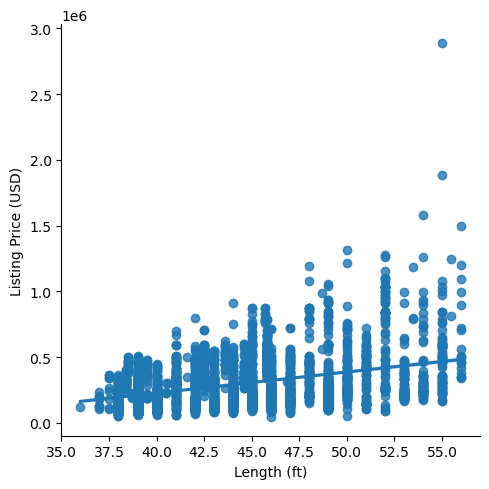

In [25]:
sns.lmplot(data=df_cleaned,x='Length (ft)',y='Listing Price (USD)')

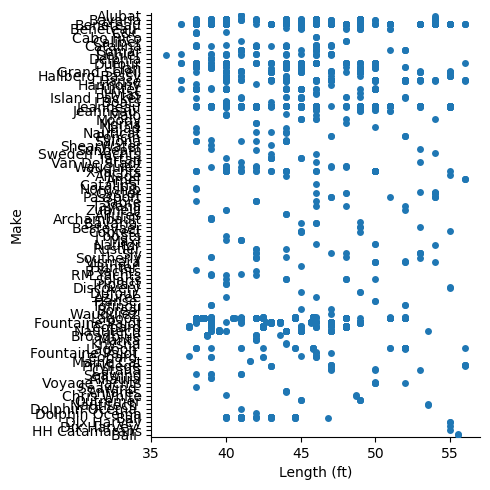

In [26]:
sns.catplot(data=df_cleaned,x='Length (ft)',y='Make')

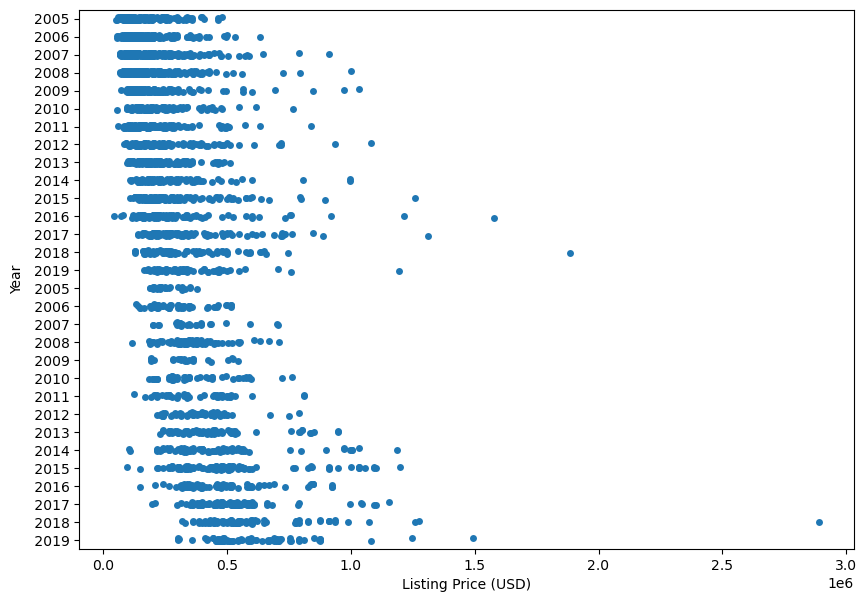

In [27]:
plt.figure(figsize=(10,7))
sns.stripplot(data=df_cleaned, x='Listing Price (USD)', y='Year')
plt.show()

## KDE plot：Geographic Region 和 Listing Price 的关系

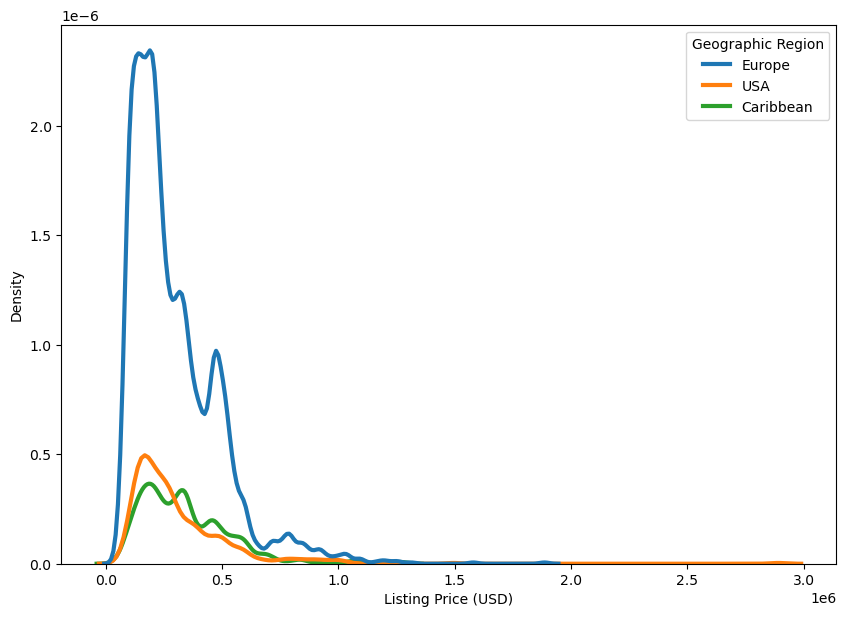

In [28]:
plt.figure(figsize=(10,7))
# sns.displot(data=df_kde, x='Listing Price (USD)', hue='Geographic Region',legend=False)
sns.kdeplot(data=df_cleaned, x='Listing Price (USD)',hue='Geographic Region',bw_adjust=.5,lw = 3)
plt.show()

## KS test:
|     |statistic|pvalue|
|:---:|:-------:|:----:|
|Europe vs. USA|0.07552315586748873|0.01722005795253017|
|Europe vs. Caribbean|0.14752914679385268|4.0166310555047366e-08|
|USA vs. Caribbean|0.17322154471544715|7.483248001932778e-07|

`均为显著不同的`

In [29]:
s1 = df_cleaned['Listing Price (USD)'][df_cleaned['Geographic Region'] == 'Europe']
s2 = df_cleaned['Listing Price (USD)'][df_cleaned['Geographic Region'] == 'USA']
res = ks_2samp(s1, s2)
res

KstestResult(statistic=0.07552315586748873, pvalue=0.01722005795253017)

In [30]:
s1 = df_cleaned['Listing Price (USD)'][df_cleaned['Geographic Region'] == 'Europe']
s2 = df_cleaned['Listing Price (USD)'][df_cleaned['Geographic Region'] == 'Caribbean']
res = ks_2samp(s1, s2)
res

KstestResult(statistic=0.14752914679385268, pvalue=4.0166310555047366e-08)

In [31]:
s1 = df_cleaned['Listing Price (USD)'][df_cleaned['Geographic Region'] == 'Caribbean']
s2 = df_cleaned['Listing Price (USD)'][df_cleaned['Geographic Region'] == 'USA']
res = ks_2samp(s1, s2)
res

KstestResult(statistic=0.17322154471544715, pvalue=7.483248001932778e-07)

## KDE plot：Geographic Region 和 Hull Num 的关系

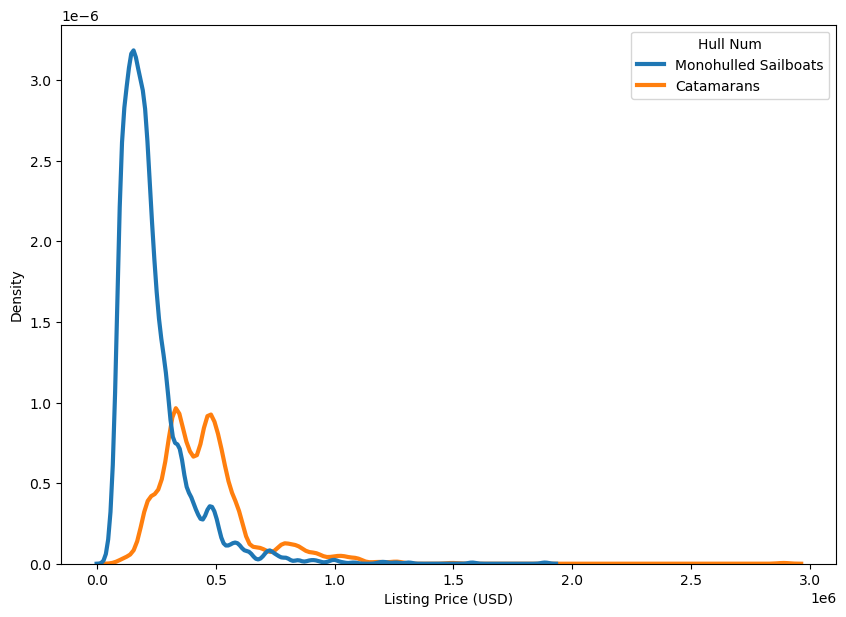

In [32]:
plt.figure(figsize=(10,7))
# sns.displot(data=df_kde, x='Listing Price (USD)', hue='Geographic Region',legend=False)
sns.kdeplot(data=df_cleaned, x='Listing Price (USD)',hue='Hull Num',bw_adjust=.5,lw = 3)
plt.show()

## KS test:
`两者的分布是显著不同的`

In [33]:
s1 = df_cleaned['Listing Price (USD)'][df_cleaned['Hull Num'] == 'Monohulled Sailboats']
s2 = df_cleaned['Listing Price (USD)'][df_cleaned['Hull Num'] == 'Catamarans']
res = ks_2samp(s1, s2)
res

KstestResult(statistic=0.6466352435108201, pvalue=8.529173023637341e-305)